## Figurative Language: Multiple Choice

Dataset Source: https://huggingface.co/datasets/nightingal3/fig-qa

#### Import Necessary Libraries

In [1]:
import os, sys, random, ast
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import Dataset, DatasetDict, load_dataset

import torch

from dataclasses import dataclass

import transformers
from transformers import AutoTokenizer, AutoModelForMultipleChoice
from transformers import Trainer, TrainingArguments, set_seed
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy

from typing import Optional, Union

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [2]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)

        Python: 3.9.12
         NumPy: 1.25.1
        Pandas: 2.0.3
         Torch: 2.0.1
      Datasets: 2.13.1
  Transformers: 4.29.1


#### Load & Process Training Dataset

In [3]:
dataset = load_dataset("nightingal3/fig-qa")

dataset

Found cached dataset csv (/Users/briandunn/.cache/huggingface/datasets/nightingal3___csv/nightingal3--fig-qa-5c54de63c3b7b7e8/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['startphrase', 'ending1', 'ending2', 'labels', 'valid'],
        num_rows: 9674
    })
    validation: Dataset({
        features: ['startphrase', 'ending1', 'ending2', 'labels', 'valid'],
        num_rows: 1094
    })
    test: Dataset({
        features: ['startphrase', 'ending1', 'ending2', 'labels', 'valid'],
        num_rows: 1146
    })
})

In [4]:
dataset['train'][12]

{'startphrase': 'It smells like a freshly baked cookies on Christmas morning',
 'ending1': 'It smells great',
 'ending2': 'It smells awful',
 'labels': 0,
 'valid': 1}

#### Convert Dataset to Pandas DataFrame

In [5]:
dataset.set_format(type='pandas', columns=['startphrase', 'ending1', 'ending2', 'labels', 'valid'])

df = pd.concat([dataset['train'][:], dataset['test'][:], dataset['validation'][:]])

df.head()

,startphrase,ending1,ending2,labels,valid
0,Her word had the strength of titanium.,Her promises can be believed.,Her promises cannot be trusted.,0,1
1,Her word had the strength of a wine glass.,Her promises can be believed.,Her promises cannot be trusted.,1,1
2,His kisses have the passion of lovers meeting ...,His kisses are demonstrative and intense.,His kiss is unemotional.,0,1
3,His kisses have the passion of a couple in a l...,His kisses are demonstrative and intense.,His kiss is unemotional.,1,1
4,This winter is as cold as my mother-in-law tow...,It's very cold,It's pretty warm,0,1


#### Rename Features as Necessary

In [6]:
df = df.rename(columns={"startphrase": "context", "ending1": "0", "ending2": "1"})

df = df.drop(columns='valid') 

df = df[df['labels'] > -1]
df = df[df['labels'] < 2]

df = df.reset_index(drop=True)

df

,context,0,1,labels
0,Her word had the strength of titanium.,Her promises can be believed.,Her promises cannot be trusted.,0
1,Her word had the strength of a wine glass.,Her promises can be believed.,Her promises cannot be trusted.,1
2,His kisses have the passion of lovers meeting ...,His kisses are demonstrative and intense.,His kiss is unemotional.,0
3,His kisses have the passion of a couple in a l...,His kisses are demonstrative and intense.,His kiss is unemotional.,1
4,This winter is as cold as my mother-in-law tow...,It's very cold,It's pretty warm,0
...,...,...,...,...
10763,Emails are as fast as a rocket,Emails are slow.,Emails are fast.,1
10764,The dinner was as tasty as a leather shoe,The dinner was very dry and tasteless.,The dinner was award winning.,0
10765,The dinner was as tasty as a Michelin star,The dinner was very dry and tasteless.,The dinner was award winning.,1
10766,The explanation was like clear water,The explanation was easy and simple to understand,The explanation made to sense.,0


#### Histogram of Input Length (in Words)

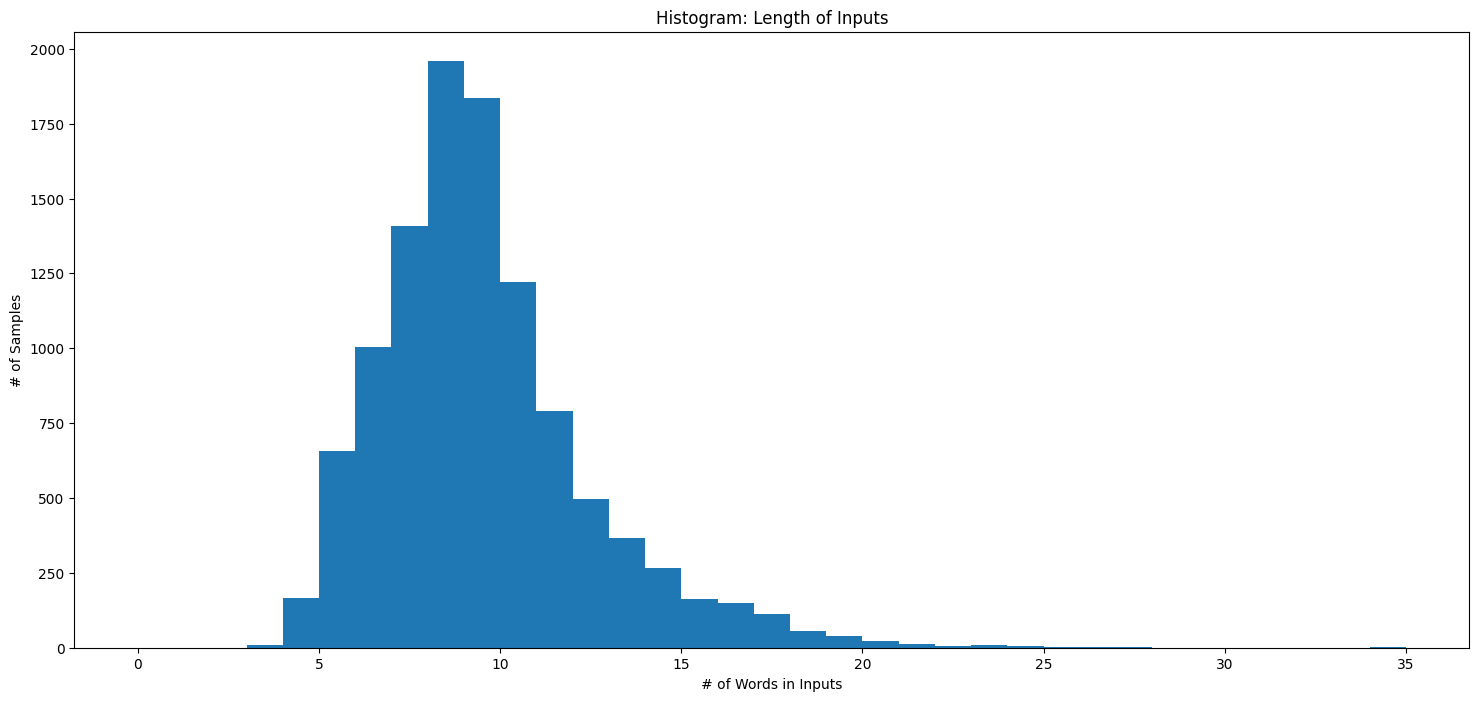

The maximum length of the inputs is 34 words.


In [7]:
df['question_length'] = df['context'].str.split().str.len()

n_bin = max(df['question_length']) + 1
df.hist('question_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of Inputs')
plt.xlabel('# of Words in Inputs')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of the inputs is {max(df['question_length'])} words.")
df = df.drop(columns=['question_length'])

#### Convert from DataFrame to Dataset & Split into Training/Testing/Evaluation Datasets

In [8]:
dataset = Dataset.from_pandas(df)

train_testeval = dataset.train_test_split(test_size=0.20)
test_eval = train_testeval['test'].train_test_split(test_size=0.50)

ds = DatasetDict({
    'train' : train_testeval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

print(ds['train'].features)

Training Dataset Shape: (8614, 4)
Testing Dataset Shape: (1077, 4)
Evaluation Dataset Shape: (1077, 4)
{'context': Value(dtype='string', id=None), '0': Value(dtype='string', id=None), '1': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None)}


#### Create Function to Display an Example Sample

In [9]:
def show_one_example(sample):
    print(f"Context: {sample['context']}")
    print(f" 0 - {sample['0']}")
    print(f" 1 - {sample['1']}")
    print(f"\nGround Truth: option {sample['labels']}")

#### Display an Example Sample

In [10]:
show_one_example(ds['train'][2])

Context: The sandwich meat was as moist as a towelette
 0 - The sandwich meat was moist.
 1 - The sandwich meat was dry.

Ground Truth: option 0


#### Basic Values/Constants

In [11]:
MODEL_CKPT = "bert-base-uncased"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Figurative_Language"

STRATEGY = "epoch"
LEARNING_RATE = 5e-5

BATCH_SIZE = 16
NUM_OF_EPOCHS = 5

WEIGHT_DECAY = 0.01
REPORTS_TO = "tensorboard"

set_seed = 42

#### Instantiate Tokenizer

In [12]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, use_fast=True)

#### Create Preprocessing Function

In [13]:
ending_names = ["0", "1"]

def preprocess_function(samples):
    input_headers = samples["context"]
    input = [[f"{header} {samples[end][i]}" for end in ending_names] for i, header in enumerate(input_headers)]
    
    input = sum(input, [])
    
    tokenized_samples = tokenizer(input, truncation=True)
    
    return {k: [v[i:i + len(ending_names)] for i in range(0, len(v), len(ending_names))] 
            for k, v in tokenized_samples.items()}

#### Apply Preprocessing Function to Dataset

In [14]:
encoded_ds = ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/8614 [00:00<?, ? examples/s]

Map:   0%|          | 0/1077 [00:00<?, ? examples/s]

Map:   0%|          | 0/1077 [00:00<?, ? examples/s]

In [15]:
encoded_ds['train'].features

{'context': Value(dtype='string', id=None),
 '0': Value(dtype='string', id=None),
 '1': Value(dtype='string', id=None),
 'labels': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None)}

In [16]:
encoded_ds['train'][25]

{'context': 'Adam is as strong as a tsunami.',
 '0': 'Adam is strong.',
 '1': 'Adam is weak.',
 'labels': 0,
 'input_ids': [[101,
   4205,
   2003,
   2004,
   2844,
   2004,
   1037,
   19267,
   1012,
   4205,
   2003,
   2844,
   1012,
   102],
  [101,
   4205,
   2003,
   2004,
   2844,
   2004,
   1037,
   19267,
   1012,
   4205,
   2003,
   5410,
   1012,
   102]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

#### Instantiate Model

In [17]:
model = AutoModelForMultipleChoice.from_pretrained(MODEL_CKPT)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 

#### Define TrainingArguments

In [18]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    evaluation_strategy=STRATEGY,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_OF_EPOCHS,
    weight_decay=WEIGHT_DECAY,
    report_to=REPORTS_TO,
    logging_first_step=True,
    group_by_length=True,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Data Collator Class

In [19]:
@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad inputs 
    for the multiple choices received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    
    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [[{k: v[i] for k, v in feature.items()} 
                               for i in range(num_choices)] for feature in features]
        flattened_features = sum(flattened_features, [])
        
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        
        # Unflatten
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        # Add back labels
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
        return batch

#### Create Function to Compute Metrics

In [20]:
def compute_metrics(predictions):
    preds, labels = predictions
    preds = np.argmax(preds, axis=1)
    return {"accuracy": (preds == labels).astype(np.float32).mean().item()}

#### Instantiate Trainer

In [21]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["eval"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(tokenizer),
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/DunnBC22/bert-base-uncased-Figurative_Language into local empty directory.


#### Train Model

In [22]:
train_results = trainer.train()

/Users/briandunn/Desktop/python_venvs/torch_cv/lib/python3.9/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2695 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.7007, 'learning_rate': 4.998144712430427e-05, 'epoch': 0.0}
{'loss': 0.6961, 'learning_rate': 4.072356215213358e-05, 'epoch': 0.93}


  0%|          | 0/68 [00:00<?, ?it/s]

{'eval_loss': 0.6931524276733398, 'eval_accuracy': 0.5190343260765076, 'eval_runtime': 72.6333, 'eval_samples_per_second': 14.828, 'eval_steps_per_second': 0.936, 'epoch': 1.0}
{'loss': 0.6595, 'learning_rate': 3.144712430426716e-05, 'epoch': 1.86}


  0%|          | 0/68 [00:00<?, ?it/s]

{'eval_loss': 0.5325652360916138, 'eval_accuracy': 0.7214484810829163, 'eval_runtime': 72.356, 'eval_samples_per_second': 14.885, 'eval_steps_per_second': 0.94, 'epoch': 2.0}
{'loss': 0.4647, 'learning_rate': 2.2170686456400745e-05, 'epoch': 2.78}


  0%|          | 0/68 [00:00<?, ?it/s]

{'eval_loss': 0.46040698885917664, 'eval_accuracy': 0.7948004007339478, 'eval_runtime': 76.2862, 'eval_samples_per_second': 14.118, 'eval_steps_per_second': 0.891, 'epoch': 3.0}
{'loss': 0.2884, 'learning_rate': 1.2894248608534323e-05, 'epoch': 3.71}


  0%|          | 0/68 [00:00<?, ?it/s]

{'eval_loss': 0.6204126477241516, 'eval_accuracy': 0.8217270374298096, 'eval_runtime': 201.1568, 'eval_samples_per_second': 5.354, 'eval_steps_per_second': 0.338, 'epoch': 4.0}
{'loss': 0.1702, 'learning_rate': 3.6178107606679037e-06, 'epoch': 4.64}


  0%|          | 0/68 [00:00<?, ?it/s]

{'eval_loss': 0.7629401087760925, 'eval_accuracy': 0.8124419450759888, 'eval_runtime': 185.9056, 'eval_samples_per_second': 5.793, 'eval_steps_per_second': 0.366, 'epoch': 5.0}
{'train_runtime': 14610.358, 'train_samples_per_second': 2.948, 'train_steps_per_second': 0.184, 'train_loss': 0.4321850755882617, 'epoch': 5.0}


#### Push to HuggingFace Hub

In [23]:
trainer.push_to_hub()

Upload file pytorch_model.bin:   0%|          | 1.00/418M [00:00<?, ?B/s]

Upload file runs/Aug01_20-54-50_Brians-Mac-mini/events.out.tfevents.1690941296.Brians-Mac-mini.35857.0:   0%| …

To https://huggingface.co/DunnBC22/bert-base-uncased-Figurative_Language
   e3eb0b1..8ac2634  main -> main

To https://huggingface.co/DunnBC22/bert-base-uncased-Figurative_Language
   8ac2634..ac9fac9  main -> main



'https://huggingface.co/DunnBC22/bert-base-uncased-Figurative_Language/commit/8ac2634393f4b9c0a7ff2aef785a47f15f39abc1'

#### Save Model & Metrics

In [24]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =        5.0
  train_loss               =     0.4322
  train_runtime            = 4:03:30.35
  train_samples_per_second =      2.948
  train_steps_per_second   =      0.184


### Notes & Other Takeaways From This Project
****
- The results are about what I was expecting.

****

#### Citation

- Dataset 
    > @misc{https://doi.org/10.48550/arxiv.2204.12632, doi = {10.48550/ARXIV.2204.12632}, url = {https://arxiv.org/abs/2204.12632}, author = {Liu, Emmy and Cui, Chen and Zheng, Kenneth and Neubig, Graham}, keywords = {Computation and Language (cs.CL), Artificial Intelligence (cs.AI), FOS: Computer and information sciences, FOS: Computer and information sciences}, title = {Testing the Ability of Language Models to Interpret Figurative Language}, publisher = {arXiv}, year = {2022}, copyright = {Creative Commons Attribution Share Alike 4.0 International}}


- Model Checkpoint
    > @article{DBLP:journals/corr/abs-1810-04805, author = {Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova}, title = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding}, journal = {CoRR}, volume = {abs/1810.04805}, year = {2018}, url = {http://arxiv.org/abs/1810.04805%7D, archivePrefix = {arXiv}, eprint = {1810.04805}, timestamp = {Tue, 30 Oct 2018 20:39:56 +0100}, biburl = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib%7D, bibsource = {dblp computer science bibliography, https://dblp.org%7D
}